# Solution Notebook


In this solution notebook we focus on these key tasks:

1. Loading and visualization of the dataset
2. Running model predictions and evaluating baseline
3. Train model to improve score over this baseline
4. Run evaluations and explain the working of both the given model and trained model


## Table of Contents


- [Imports](#imports)
- [Dataset Exploration](#dataset-exploration)
  - [Loading Dataset](#loading-dataset)
- [Data Plots](#data-plots)
  - [Histogram Plot for Distribution](#histogram-plot-for-distribution)
  - [Visual Image Plot](#visual-image-plot)
  - [PCA Visualizations](#pca-visualizations)
  - [Pixel-Label Correlation Plots](#pixel-label-correlation-plots)


## Imports


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from collections import Counter

from scripts.dataset_loader import load_dataset
from scripts.exploration_plots import (
    plot_pca_2d,
    plot_pca_3d,
    plot_pixel_label_patterns,
    plot_combined_image,
)

## Dataset Exploration


### Loading Dataset


Let's load the dataset as a `tf.data.Dataset` object


In [3]:
dataset, images, labels = load_dataset()

From here we observe that there are **1000** images of size **16x16**. Each image either has the label as `1` or `0`


In [4]:
print(">> Labels")
print("Shape:", labels.shape)

print("> Unique labels")
print(set(labels))

print("> Single Image Labels")
print(labels[0])
print(labels[800])

print()
print(">> Images")
print("Shape:", images.shape)

print("> Single Image")
print("Shape:", images[0, :, :].shape)
print(images[0, :, :])

>> Labels
Shape: (1000,)
> Unique labels
{0, 1}
> Single Image Labels
0
1

>> Images
Shape: (1000, 16, 16)
> Single Image
Shape: (16, 16)
[[2.1700313  0.3368357  0.5888369  0.6597585  1.138681   0.35873774
  1.8572135  0.83504444 0.18155456 0.7893587  0.9517998  0.02187085
  0.6317337  0.5083703  0.8277021  0.80548126]
 [1.3674951  0.30677652 0.140921   0.14598766 0.16792616 1.6860738
  0.04102432 0.20599899 0.7848744  0.19453607 0.20928012 0.45434618
  0.9031863  0.9356227  0.6061106  2.181677  ]
 [0.0622947  0.52064    0.48904428 1.5958955  0.49071908 2.7082717
  0.06556757 0.2904863  0.2859103  1.0856764  0.05776405 1.1728171
  1.5814979  1.3288999  0.01713689 1.1861597 ]
 [1.2270731  0.08372566 0.8707939  2.5772567  0.07647876 0.48341855
  0.18920054 0.11365169 0.8503427  0.5787239  0.17180316 0.8009488
  0.95969856 0.3596137  0.8661315  0.04501369]
 [0.2039771  2.4431734  0.35061747 1.838147   0.2763531  2.2010422
  0.3528849  0.18543014 0.9194601  1.3772079  0.348033   0.49081576

## Data Plots



### Histrogram plot for distribution



Let's check how this data is distributed. The plot indicates an equitable 50-50 split on the labels!


Label distribution:
Label 0: 500 images
Label 1: 500 images


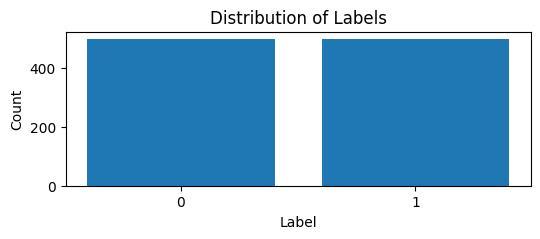

In [5]:
label_counts = Counter(labels)
print("Label distribution:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} images")

plt.figure(figsize=(6, 2))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.xticks(list(label_counts.keys()))
plt.show()

### Visual Image Plot


- On Visual inspection of the data, The images have distinct visual features. We have this _Signal vs Background_ like dynamic.
- Label 1 shows a concentrated high-energy cluster (signal)
- Label 0 appears more diffused image (background).


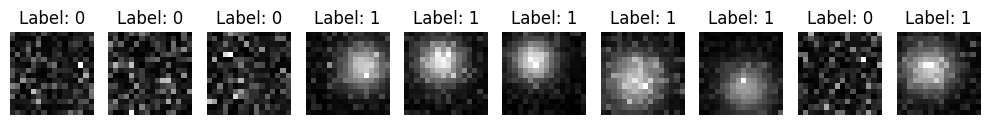

In [6]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### PCA Visualizations


- Let's validate our intuition that the two images are easy to distinguish.
- First, we'll flatten each image into a vector and then decompose it into two and three principal component along with their labels.
- We observe again see how well they separate in the plots.


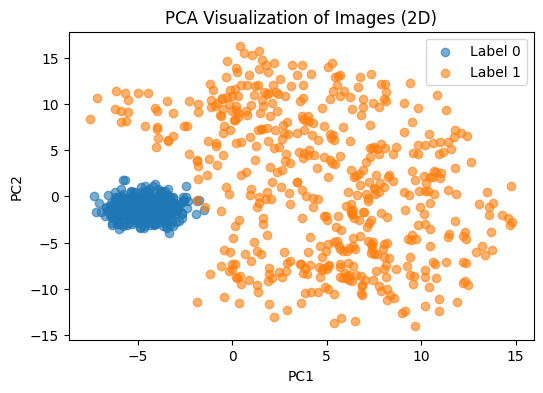

In [7]:
label_mapping = {0: "Label 0", 1: "Label 1"}

plot_pca_2d(images, labels, label_mapping)

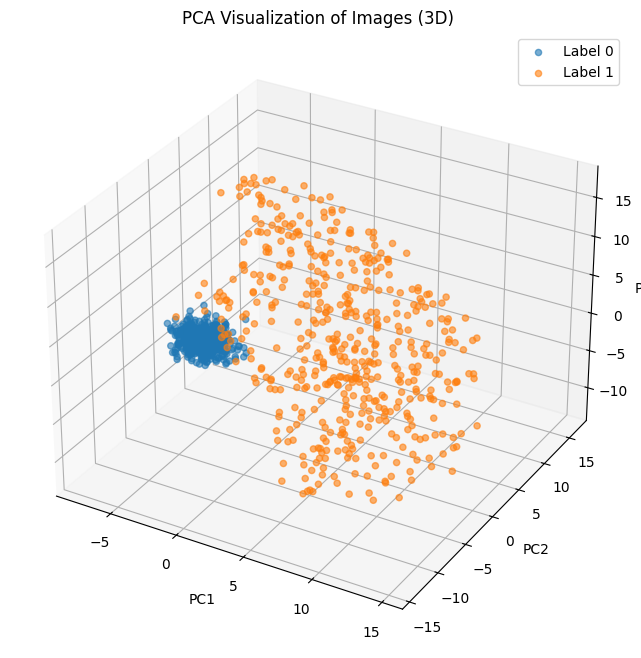

In [8]:
plot_pca_3d(images, labels, label_mapping)

### Pixel-Label Correlation plots

We try two different methods to explore pixel–label relationships and observe that both yield similar patterns in the resulting maps.

1. **Difference Map**:

- We calculate the average image for labels 0 and 1, then deduct the average from the label. This shows the areas where label 1 photos are generally darker (negative/blue) or brighter (positive/red) than label 0 images.

2. **Pixel-wise Correlation**:

- We calculate the Pearson correlation coefficient between the label (0 or 1) and the intensity of each pixel. This indicates the degree to which the brightness of each pixel is linked to either label 0 or label 1.

**Overall Inference:**
The primary characteristic that sets the two labels apart is that the centre region is brighter for label 1, while the surrounding ring is more typical of label 0. This is confirmed by both the difference map and the pixel-wise correlation map.


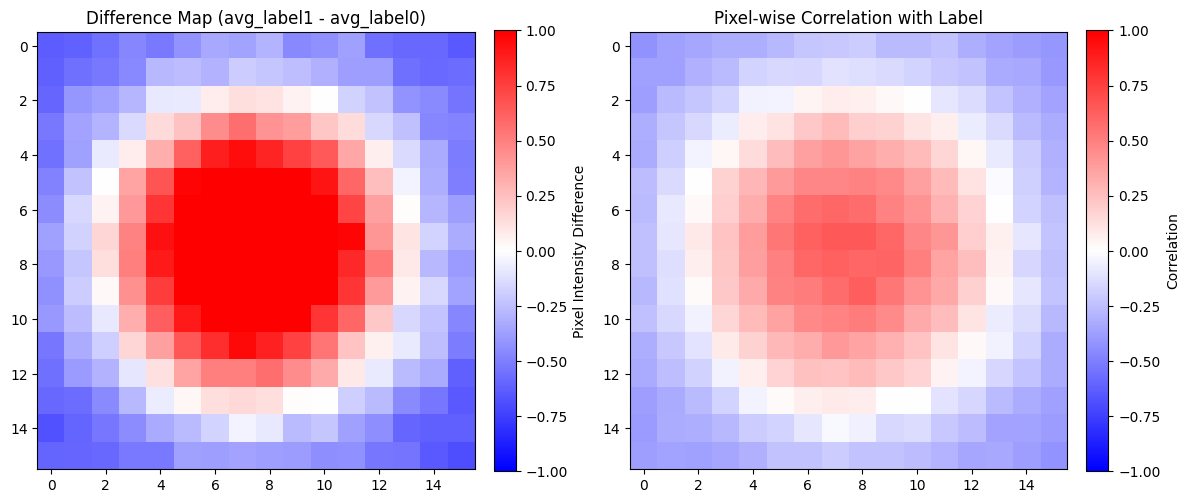

In [9]:
plot_pixel_label_patterns(images, labels)

Another way to intuitively visualize this is by taking 5 images and literally squashing them together into one. We see again this large `vignette-like` region in the center


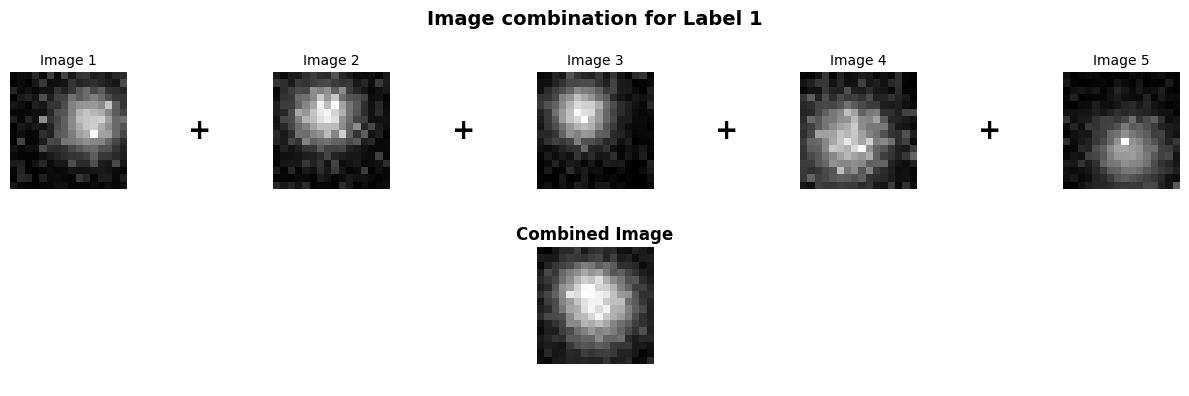

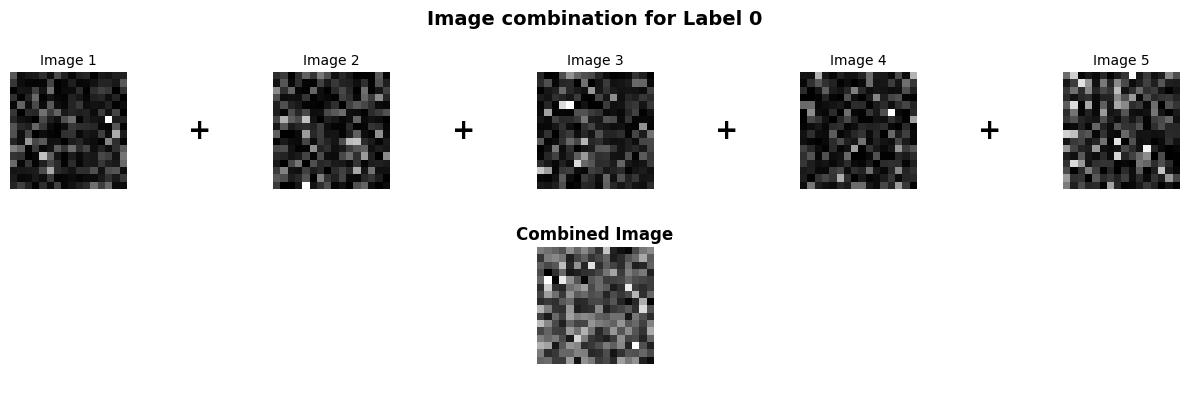

In [11]:
plot_combined_image(images, labels, label_target=1)
plot_combined_image(images, labels, label_target=0)